In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     TimeSeriesSplit,
                                     cross_val_score)

# Classifier
from xgboost import XGBClassifier, plot_importance, to_graphviz

# Metrics
from sklearn.metrics import (precision_recall_curve,
                             roc_curve,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay)
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             auc)
from sklearn.metrics import (classification_report,
                             confusion_matrix)

In [4]:
# Load file
df = pd.read_csv('data/spy.csv', index_col=0, parse_dates=True)[['Adj Close']]

# Calculate returns
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
df.dropna(inplace=True)

# Output first five rows
df.head()

,Adj Close,Returns,Ret_1M
Date,,,
1928-01-31,17.570000,0.004564,-0.010756
1928-01-02,17.530001,-0.002279,-0.010780
1928-02-02,17.629999,0.005688,0.004548
1928-03-02,17.400000,-0.013132,-0.014832
1928-06-02,17.450001,0.002869,-0.002861


In [6]:
# Descriptive statistics
df.describe()

,Adj Close,Returns,Ret_1M
count,23953.000000,23953.000000,23953.000000
mean,586.438394,0.000230,0.004574
std,931.329592,0.012013,0.053578
min,4.400000,-0.228997,-0.548062
25%,24.510000,-0.004577,-0.019324
50%,101.500000,0.000480,0.009589
75%,965.539978,0.005442,0.033230
max,4796.560059,0.153661,0.479470


In [7]:
# Check for missing values
df.isnull().sum()

Adj Close    0
Returns      0
Ret_1M       0
dtype: int64

In [9]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

df.dropna(inplace=True)

In [17]:
# Define target
df['Target'] = np.where(df['Adj Close'].shift(-1) > 0.995*df['Adj Close'], 1, 0)
df = df[:-1]

# Check output
df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
1928-04-26,19.469999,0.007216,0.030242,0.003086,0.009348,0.024962,0.009637,0.030242,0.010300,0.043029,...,0.008761,0.129212,0.008331,0.110108,0.008616,0.109535,0.008294,0.107245,0.008214,1
1928-04-27,19.680000,0.010728,0.037799,-0.002537,0.008396,0.023131,0.009500,0.037799,0.010501,0.056441,...,0.008844,0.138772,0.008408,0.123133,0.008674,0.120836,0.008369,0.113410,0.008287,1
1928-04-30,19.750000,0.003551,0.024085,0.003551,0.008433,0.024604,0.009513,0.024085,0.009873,0.050361,...,0.008829,0.139408,0.008408,0.129561,0.008640,0.121524,0.008371,0.119240,0.008272,1
1928-01-05,19.780001,0.001518,0.044980,0.013232,0.007884,0.034983,0.009062,0.044980,0.008604,0.037604,...,0.008608,0.145008,0.008341,0.149108,0.008115,0.119617,0.008370,0.115069,0.008258,1
1928-02-05,19.830000,0.002525,0.041705,0.015756,0.007878,0.019863,0.008017,0.041705,0.008564,0.045920,...,0.008597,0.144615,0.008341,0.156928,0.008027,0.122712,0.008361,0.130726,0.008018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,4179.830078,-0.006127,0.014519,0.016872,0.008594,0.014619,0.007339,0.014519,0.008000,0.026227,...,0.007791,0.049610,0.007936,0.056158,0.008141,0.080702,0.008621,0.031944,0.009129,1
2023-01-06,4221.020020,0.009806,0.031348,0.014857,0.008350,0.019951,0.007643,0.031348,0.008027,0.039882,...,0.007866,0.060991,0.008030,0.053065,0.008062,0.074166,0.008456,0.057196,0.008961,1
2023-02-06,4282.370117,0.014430,0.053023,0.019887,0.009006,0.036079,0.008294,0.053023,0.008235,0.034935,...,0.008139,0.061284,0.008040,0.084095,0.007866,0.095601,0.008557,0.070212,0.009128,1


In [18]:
# Convert to numpy
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'], axis=1)
X.values

array([[ 0.00308637,  0.00934809,  0.02496224, ...,  0.00829429,
         0.10724548,  0.00821372],
       [-0.00253743,  0.00839641,  0.02313133, ...,  0.00836922,
         0.11340999,  0.00828726],
       [ 0.0035506 ,  0.00843306,  0.02460401, ...,  0.00837075,
         0.11923974,  0.00827171],
       ...,
       [ 0.01988654,  0.00900572,  0.03607908, ...,  0.00855687,
         0.07021176,  0.00912824],
       [ 0.01932786,  0.0090311 ,  0.03565805, ...,  0.00829486,
         0.08683802,  0.00876194],
       [ 0.02152397,  0.00900974,  0.03505538, ...,  0.00811687,
         0.10377312,  0.00850579]])

In [19]:
# Define label or target
y = df['Target']
y

Date
1928-04-26    1
1928-04-27    1
1928-04-30    1
1928-01-05    1
1928-02-05    1
             ..
2023-05-31    1
2023-01-06    1
2023-02-06    1
2023-05-06    1
2023-06-06    1
Name: Target, Length: 23892, dtype: int32

In [20]:
# Splitting the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Output the train and test data size
print(f'Train and Test Size: {len(X_train), len(X_test)}')

Train and Test Size: (19113, 4779)


In [21]:
# Scale and fit the classifier model
model = XGBClassifier(verbosity=0, silent=True, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict probabilities 
y_proba = model.predict_proba(X_test)

In [24]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.8706, Test Accuracy: 0.7548


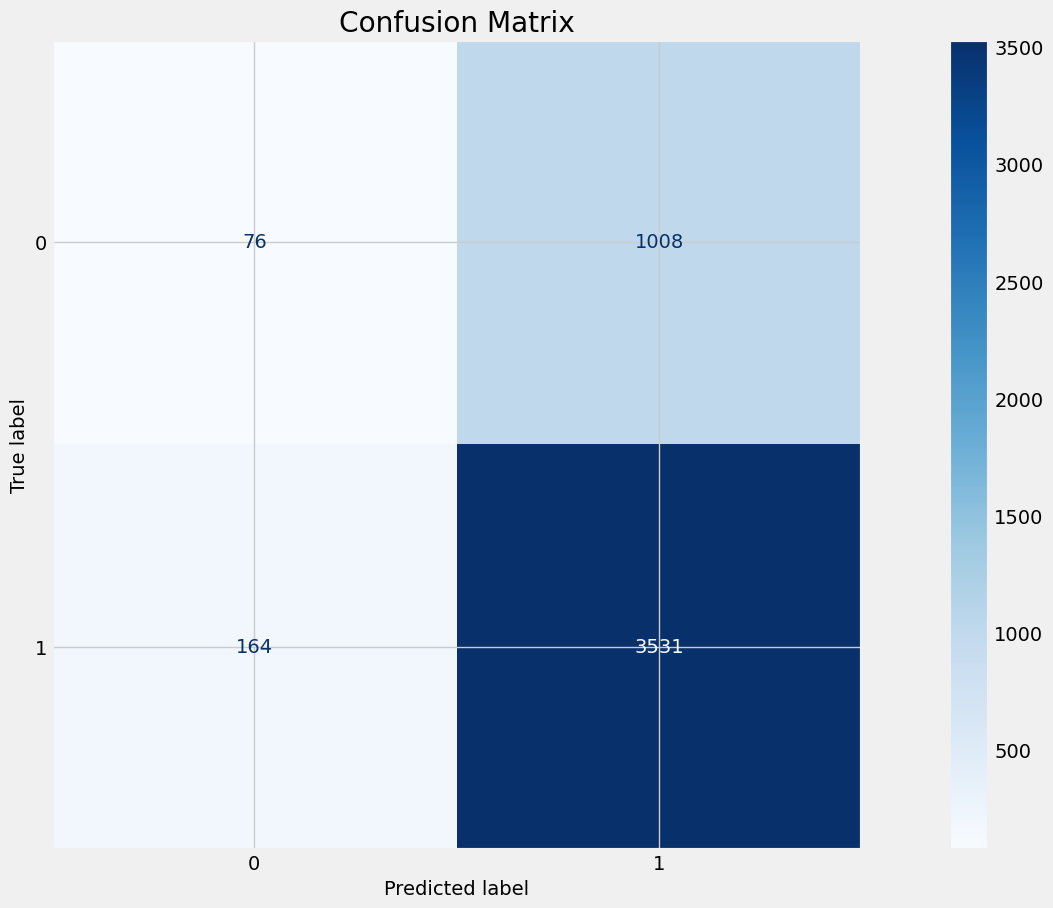

In [26]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model,
                                             X_test,
                                             y_test,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.07      0.11      1084
           1       0.78      0.96      0.86      3695

    accuracy                           0.75      4779
   macro avg       0.55      0.51      0.49      4779
weighted avg       0.67      0.75      0.69      4779



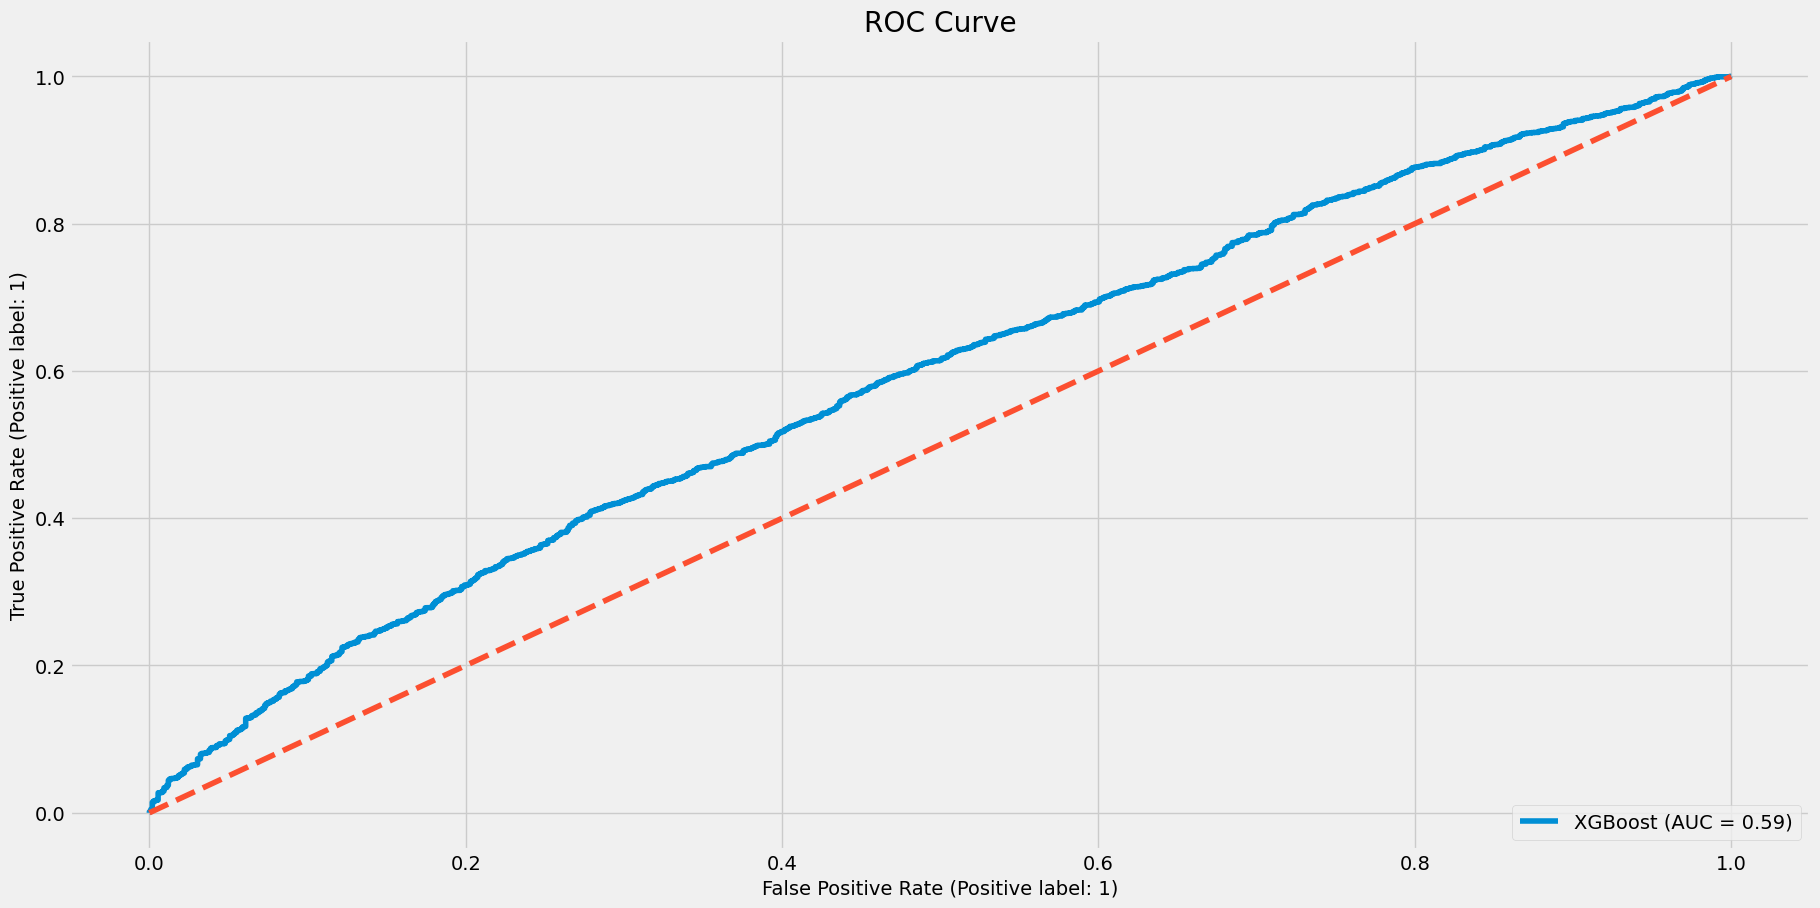

In [28]:
# Display Roc Curve
disp_roc = RocCurveDisplay.from_estimator(model,
                                          X_test,
                                          y_test,
                                          name='XGBoost')
plt.title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()